## Introduction

In this project, going to use spacy for entity recognition on 200 Resume and experiment around various NLP tools for text analysis. The main purpose of this project is to help recruiters go throwing hundreds of applications within a few minutes. We have also added skills match feature so that hiring managers can follow a metric that will help them to decide whether they should move to the interview stage or not. We will be using two datasets; the first contains resume texts and the second contains skills that we will use to create an entity ruler.

## Dataset

livecareer.com resume Dataset
A collection of 2400+ Resume Examples taken from livecareer.com for categorizing a given resume into any of the labels defined in the dataset: [Resume Dataset](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset)

### Inside the CSV
ID: Unique identifier and file name for the respective pdf.
Resume_str : Contains the resume text only in string format.
Resume_html : Contains the resume data in html format as present while web scrapping.
Category : Category of the job the resume was used to apply.

### Present categories
HR, Designer, Information-Technology, Teacher, Advocate, Business-Development, Healthcare, Fitness, Agriculture, BPO, Sales, Consultant, Digital-Media, Automobile, Chef, Finance, Apparel, Engineering, Accountant, Construction, Public-Relations, Banking, Arts, Aviation

### Acknowledgements
Data was obtained by scrapping individual resume examples from www.livecareer.com website. Web Scrapping code present in my Github Repo.

### Jobzilla skill patterns
The jobzilla skill dataset is jsonl file containing different skills that can be used to create spaCy entity_ruler. The data set contains label and pattern-> diferent words used to descibe skills in various resume.

## Import Libraries

In [1]:
import spacy
from spacy.cli import download
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings 
warnings.filterwarnings('ignore')

/Users/sakib/anaconda3/lib/python3.11/site-packages/plotly/express/imshow_utils.py:24: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
[nltk_data] Downloading package stopwords to /Users/sakib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sakib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading
In this section, I am going to load the spaCy model, Resume Dataset, and Jobzilla skills dataset directly into the entity ruler.

## Resume Dataset
Using Pandas read_csv to read dataset containing text data about Resume.



In [10]:
data = pd.read_csv("Resume/Resume.csv")
data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [5]:
download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.1 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: /Users/sakib/anaconda3/bin/python -m pip install --upgrade pip


In [7]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"

## Entity Ruler
To create an entity ruler we need to add a pipeline and then load the .jsonl file containing skills into ruler. As you can see we have successfully added a new pipeline entity_ruler. Entity ruler helps us add additional rules to highlight various categories within the text, such as skills and job description in our case.

In [8]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

## Skills
I will create two python functions to extract all the skills within a resume and create an array containing all the skills. Later we are going to apply this function to our dataset and create a new feature called skill. This will help us visualize trends and patterns within the dataset.

`get_skills` is going to extract skills from a single text.
`unique_skills` will remove duplicates.

In [9]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

## Cleaning Resume Text
Going to use nltk library to clean our dataset in a few steps:

- Going to use regex to remove hyperlinks, special characters, or punctuations.
- Lowering text
- Splitting text into array based on space
- Lemmatizing text to its base form for normalizations
- Removing English stopwords
- Appending the results into an array.

In [11]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

## Applying functions
In this section, going to apply all the functions we have created previously

- creating Clean_Resume columns and adding cleaning Resume data.
- creating skills columns, lowering text, and applying the get_skills function.
- removing duplicates from skills columns.
> As we can see below that we have cleaned the resume and skills columns.

In [30]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admini...,"[interaction, swift, advertising, support, doc..."
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist u hr operation summary versatile...,"[advertising, support, material, design, marke..."
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary 20 year experience recruit...,"[security, advertising, support, tracking syst..."
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven dynamic...,"[documentation, process management, certificat..."
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlight hr skill hr departm...,"[support, business, project management, box, b..."


## Visualization
Now that we have everything we want, going to visualize Job distributions and skill distributions.

## Jobs Distribution
As we can see our resume samples contain a variety of job categories. Accountants, Business development, and Advocates are the top categories.

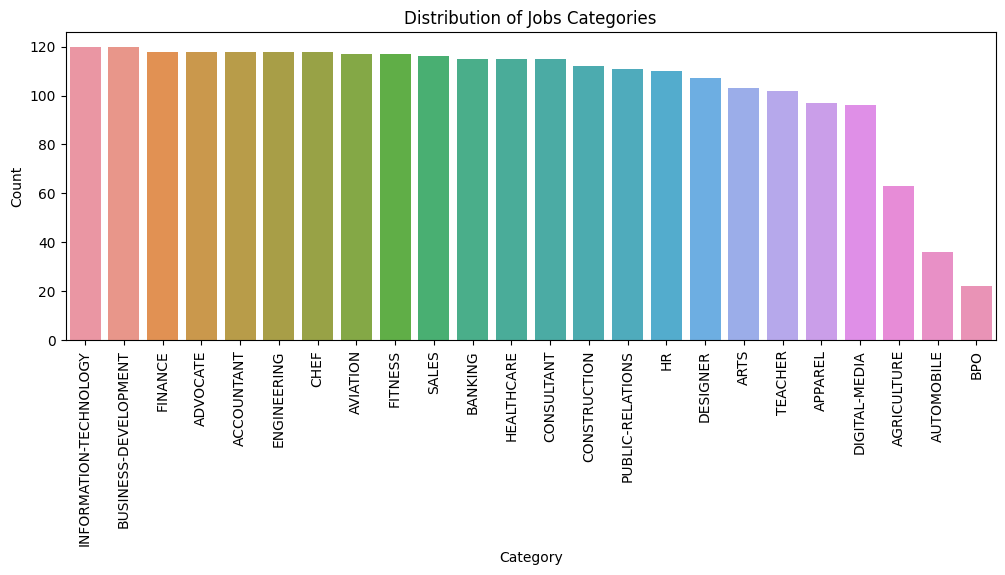

In [81]:
# Count occurrences of each category
category_counts = data['Category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Set the category order based on the counts (descending)
category_order = category_counts['Category']

# Create the count plot with Seaborn
plt.figure(figsize=(12, 4))
sns.countplot(data=data, x='Category', order=category_order)

# Customize the plot
plt.title('Distribution of Jobs Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x labels for better readability if needed

# Show the plot
plt.show()

## Skills
In this part, going to use the Deepnote input cell to create category variables and then visualize the distribution of skills based on selected Job Descriptions.


In [46]:
import pandas as pd
import plotly.express as px
import numpy as np

# Define the job category to filter by
Job_Category = "INFORMATION-TECHNOLOGY"

# Filter the data to only include the specified job category
fltr = data[data["Category"] == Job_Category]["skills"]

# Initialize a list to store all skills
Total_skills = []

# Extract skills from the filtered data
for x in fltr:
    for i in x:
        Total_skills.append(i)

# Convert the list of skills to a DataFrame for easier manipulation
skills_df = pd.DataFrame(Total_skills, columns=['Skill'])

# Count the occurrences of each skill
skills_count = skills_df['Skill'].value_counts().reset_index()
skills_count.columns = ['Skill', 'Count']

# Plot the distribution of skills using a histogram
fig = px.bar(
    skills_count,
    x='Skill',
    y='Count',
    labels={"Skill": "Skills", "Count": "Count"},
    title=f"{Job_Category} Distribution of Skills"
).update_xaxes(categoryorder="total descending")

# Show the plot
fig.show()


## Most used words
In this part, I am going to display the most used words in the Resume filter by job category. In Information technology, the most words used are system, network, and database. We can also discover more patterns by exploring the word cloud below.

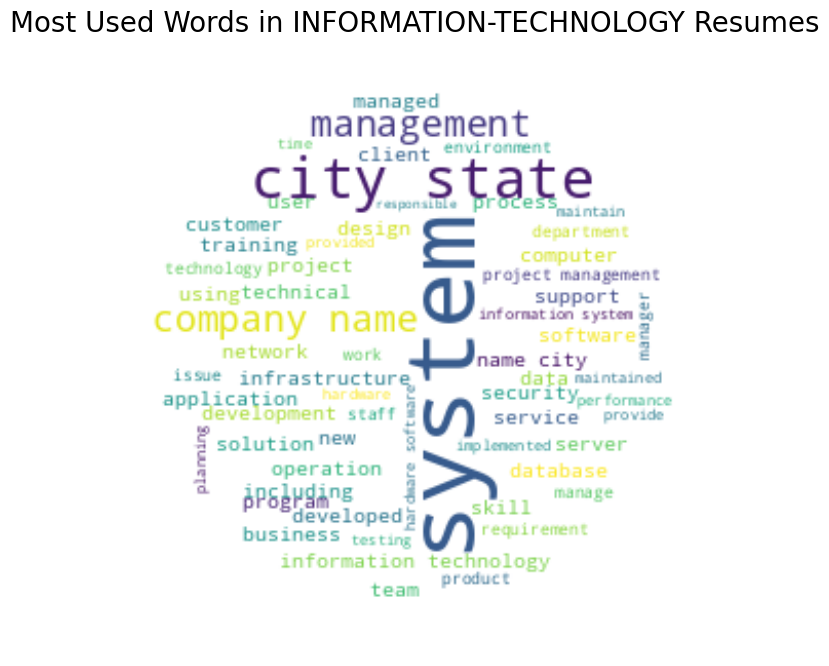

In [47]:
# Concatenate all resume texts for the specified job category
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

# Create a circular mask for the word cloud
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

# Generate the word cloud
wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
).generate(text)

# Plot the word cloud
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resumes", fontsize=20)
plt.show()


## Entity Recognition
We can also display various entities within our raw text by using spaCy displacy.render. I am in love with this function as it is an amazing way to look at your entire document and discover SKILL or GEP within your Resume.

In [48]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

## Dependency Parsing
We can also visualize dependencies by just changing style to dep as shown below. We have also limited words to 10 which includes space too. Limiting the words will make it visualize the small chunk of data and if you want to see the dependency, you can remove the filter.



In [49]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

## Custom Entity Recognition
In our case, I have added a new entity called SKILL and is displayed in gray color. I was not impressed by colors and I also wanted to add another entity called Job Description so I started experimenting with various parameters within `displace.

- Adding Job-Category into entity ruler.
- Adding custom colors to all categories.
- Adding gradient colors to SKILL and Job-Category
- You can see the result below as the new highlighted texts look beautiful.

In [51]:
patterns = data.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [52]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

## Any Resume Anlaysis
In this part, I am allowing users to copy&paste their resumes and see the results.

As we can see my I have added my Resume and the results are amazing. The model has successfully highlighted all the skills.

In [79]:
import spacy
from spacy import displacy
from ipywidgets import widgets
from IPython.display import display, HTML

# Create a text area widget
text_area = widgets.Textarea(
    placeholder='Type or paste your resume here...',
    description='Resume:',
    layout=widgets.Layout(width='70%', height='200px')
)

# Define a function to process the input and display results
def process_resume(resume_text):
    # Process the text with spaCy
    doc = nlp(resume_text)
    
    # Render the named entities with displacy
    html = displacy.render(doc, style="ent", jupyter=True)
    display(HTML(html))

# Create a button to submit the resume
button = widgets.Button(description="Submit")
button.on_click(lambda b: process_resume(text_area.value))

# Display the widgets
display(text_area, button)

Textarea(value='', description='Resume:', layout=Layout(height='200px', width='70%'), placeholder='Type or pas…

Button(description='Submit', style=ButtonStyle())

## Match Score
In this section, I am allowing recruiters to add skills and get a percentage of match skills. This can help them filter out hundreds of Resumes with just one button.

Please add the skills that are required by the job description without space in between commas and it will print out the percentage of match skills within the resume.

In [78]:
import ipywidgets as widgets
from IPython.display import display

# Dummy functions for skills extraction (replace with actual implementations)
def get_skills(resume_text):
    # Example: skills are words longer than 3 chars
    return [word.strip() for word in resume_text.split() if len(word) > 3]  

def unique_skills(skills_list):
    return list(set(skills_list))

def calculate_match(req_skills, resume_skills):
    score = 0
    for skill in req_skills:
        if skill in resume_skills:
            score += 1
    req_skills_len = len(req_skills)
    match = round(score / req_skills_len * 100, 1) if req_skills_len > 0 else 0
    return match

# Widgets for input
resume_text_area = widgets.Textarea(
    placeholder='Type or paste your resume here...',
    description='Resume:',
    layout=widgets.Layout(width='70%', height='200px')
)

skills_text_area = widgets.Textarea(
    placeholder='Type or paste the required skills here, separated by commas...',
    description='Skills:',
    layout=widgets.Layout(width='70%', height='100px')
)

output_area = widgets.Output()

# Function to process input and display results
def process_data(button):
    resume_text = resume_text_area.value
    skills_text = skills_text_area.value.lower()
    
    # Process skills
    req_skills = [skill.strip() for skill in skills_text.split(",")]
    resume_skills = unique_skills(get_skills(resume_text.lower()))
    
    # Calculate match percentage
    match = calculate_match(req_skills, resume_skills)
    
    # Display results
    with output_area:
        output_area.clear_output()
        print(f"The current Resume is {match}% matched to your requirements")

# Button to trigger processing
process_button = widgets.Button(description="Process")
process_button.on_click(process_data)

# Display widgets
display(resume_text_area, skills_text_area, process_button, output_area)

Textarea(value='', description='Resume:', layout=Layout(height='200px', width='70%'), placeholder='Type or pas…

Textarea(value='', description='Skills:', layout=Layout(height='100px', width='70%'), placeholder='Type or pas…

Button(description='Process', style=ButtonStyle())

Output()

## Topic Modeling - LDA
LDA, or Latent Dirchlet Allocation is arguably the most famous topic modeling algorithm out there. Out here we create a simple topic model with 4 topics.

In [76]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=50, 
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.013*"management" + 0.011*"company" + 0.010*"state" + 0.009*"city" + 0.009*"business" + 0.009*"project" + 0.007*"name" + 0.007*"financial" + 0.007*"customer" + 0.006*"sale"'),
 (1,
  '0.014*"system" + 0.007*"project" + 0.007*"state" + 0.006*"city" + 0.006*"company" + 0.006*"design" + 0.006*"technical" + 0.005*"data" + 0.005*"support" + 0.005*"management"'),
 (2,
  '0.014*"customer" + 0.014*"state" + 0.012*"city" + 0.010*"company" + 0.009*"service" + 0.009*"student" + 0.009*"name" + 0.008*"skill" + 0.006*"school" + 0.005*"work"'),
 (3,
  '0.012*"marketing" + 0.011*"company" + 0.010*"state" + 0.009*"city" + 0.009*"medium" + 0.008*"management" + 0.008*"relation" + 0.007*"event" + 0.007*"communication" + 0.007*"name"')]

## pyLDAvis
The best way to visualize Topics is to use pyLDAvis from GENSIM.

- topic #1 appears to relate to the customer, state, and city.
- topic #2 relates to management and marketing.
- topic #3 relates to systems and projects.
- topic #4 relates to financial and company.

In [77]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.008907  0.019117       1        1  33.561933
2      0.066052 -0.123487       2        1  27.663576
3      0.090152  0.098796       3        1  21.394727
1     -0.165112  0.005574       4        1  17.379764, topic_info=            Term         Freq        Total Category  logprob  loglift
170    marketing  4428.000000  4428.000000  Default  30.0000  30.0000
277       system  6783.000000  6783.000000  Default  29.0000  29.0000
174       medium  3070.000000  3070.000000  Default  28.0000  28.0000
769      student  4120.000000  4120.000000  Default  27.0000  27.0000
231     relation  2856.000000  2856.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
106   experience  1130.768158  5695.232933   Topic4  -5.4702   0.1331
288     training  1099.310923  5743.861894   Topic4  -5.4984   0.0964
279         team  1076.569624  6788.363152   Topic4  -5.5193  -0.0916
657  information   992.130252  4254.593007   Topic4  -5.6010   0.2940
466      process   948.992531  4552.589504   Topic4  -5.6454   0.1818

[369 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
308       1  0.190933   2014
308       2  0.438561   2014
308       3  0.226779   2014
308       4  0.143749   2014
5686      4  0.989979     3d
...     ...       ...    ...
1082      1  0.070985  wrote
1082      2  0.040563  wrote
1082      3  0.788943  wrote
1082      4  0.099378  wrote
5969      4  0.989370    xml

[738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

## Conclusion
In this project, we have used an entity ruler to create additional entities and then displayed them using custom colors. We have also visualized categories and skills distributions and allowed the user to add resumes directly which includes skills match percentage. Finally, we have used LDA for topic modeling and used pyLDAvis to visualize various topics.

Overall, it was a learning experience for me as I have never used spaCy in depth. I have also discovered various ways on how my project can be used to improve the hiring process in filtering out the perfect candidate for the job.
